X_train shape: (59, 200, 200, 3)
y_train shape: (59,)
y_train [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5]


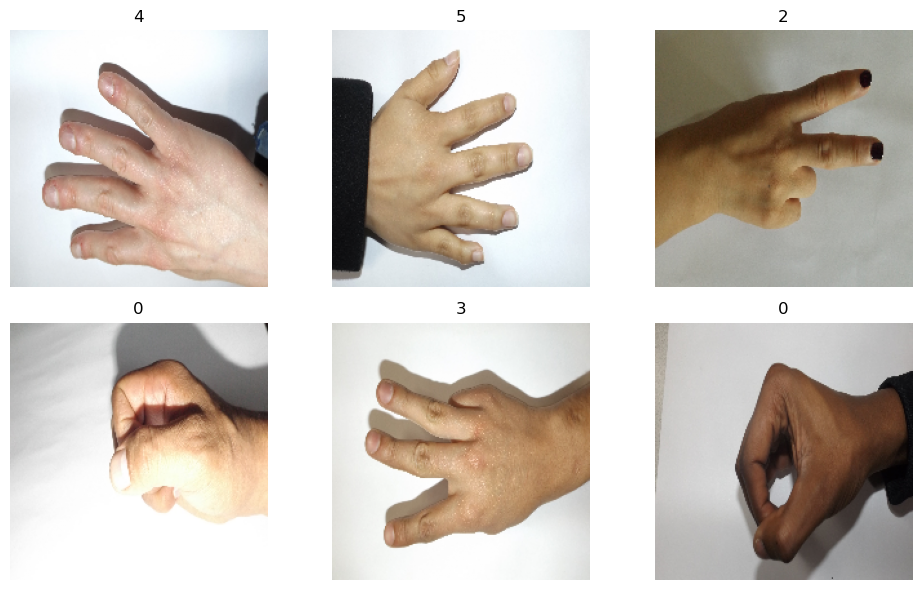

In [280]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.neighbors as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

# Define the directory containing the digit folders
data_dir = 'dataset_sample/men/'

additional_data_dir = 'dataset_sample/women/'

# Define the image size for preprocessing
img_size = (200, 200)

# Define the label names and corresponding integer values
label_names = ['0', '1', '2', '3', '4', '5']
label_dict = {label_names[i]: i for i in range(len(label_names))}

# Initialize empty lists for the images and labels
images = []
labels = []

# Loop over the digit folders (men and women)
for data_folder in [data_dir, additional_data_dir]:
    # Loop over the label names
    for label_name in label_names:
        # Get the path to the label folder
        label_dir = os.path.join(data_folder, label_name)
        # Loop over the images in the label folder
        for file_name in os.listdir(label_dir):
            # Get the path to the image file
            file_path = os.path.join(label_dir, file_name)
            # Load the image file and preprocess it
            img = cv2.imread(file_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, img_size)
            img_normalized = img_resized / 255.0
            # Append the preprocessed image and corresponding label to the lists
            images.append(img_normalized)
            labels.append(label_dict[label_name])

# Convert the image and label lists to numpy arrays
X_train = np.array(images)
y_train = np.array(labels)

sorted_indices = np.argsort(y_train)
X_train = X_train[sorted_indices]
y_train=np.asarray(sorted(y_train))

# Print the shape of the training data
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('y_train', y_train)

# Create a subplot with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

# Display the images
for i in range(6):
    random_index = random.randint(0, X_train.shape[0]-1)
    axes[i].imshow(X_train[random_index], cmap='gray')
    axes[i].set_title(label_names[y_train[random_index]])
    axes[i].axis('off')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [281]:
def remove_shadows(image):
    # convert to LAB color space
    # print('image', image.dtype)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        

    # split the LAB channels
    l, a, b = cv2.split(lab)
    
    # apply the Retinex algorithm to the L channel
    # set the gain to 128 for best results
    l = cv2.createCLAHE(clipLimit=1, tileGridSize=(3,3)).apply(l)
    # merge the LAB channels back together
    lab = cv2.merge((l,a,b))

    # convert back to BGR color space
    result = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return result

In [282]:
X_train_processed = []
for i in range(len(X_train)):
    img = X_train[i]
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) # convert to 8-bit
    img = cv2.GaussianBlur(img, (3, 3), 0)
    # Apply Gaussian blur with kernel size of 3 
    img = remove_shadows(img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    # # Apply Canny edge detector with minVal of 100 and maxVal of 200
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # img = cv2.Canny(img, 50, 200)
    # # Apply Otsu's thresholding
    # Append the preprocessed image to the list
    X_train_processed.append(img)
X_train_processed = np.array(X_train_processed)
# Print the shape of the preprocessed training data
print('X_train_processed shape:', X_train_processed.shape)

X_train_processed shape: (59, 200, 200)


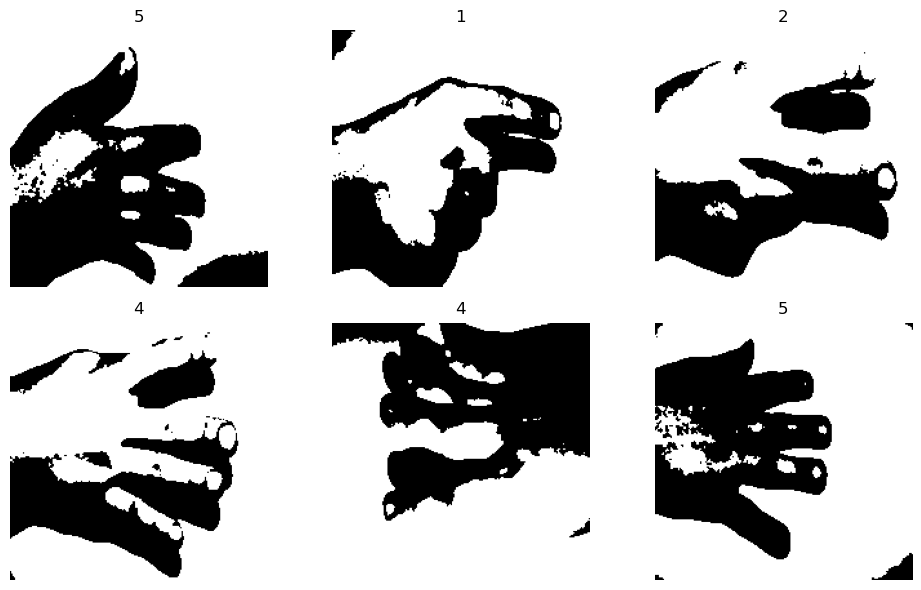

In [320]:
# Create a subplot with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

random_indices=[]
# Display the images
for i in range(6):
    random_index = random.randint(0, X_train.shape[0]-1)
    random_indices.append(random_index)
    axes[i].imshow(X_train_processed[random_index], cmap='gray')
    axes[i].set_title(label_names[y_train[random_index]])
    axes[i].axis('off')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()



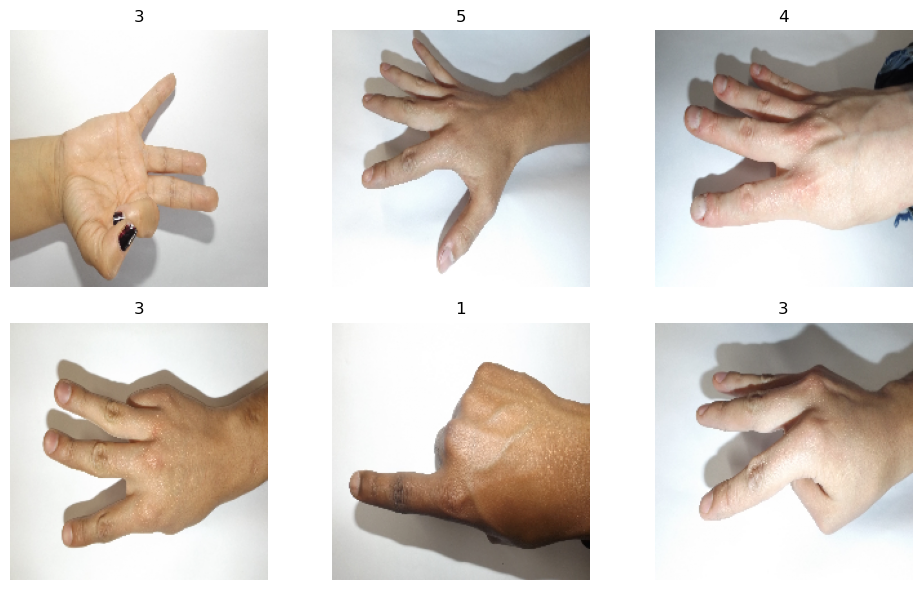

In [284]:
# Create a subplot with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

# Display the images
for counter,value in enumerate(random_indices):
    axes[counter].imshow(X_train[value], cmap='gray')
    axes[counter].set_title(label_names[y_train[value]])
    axes[counter].axis('off')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [285]:
def extract_features(binary_img):
    height, width = binary_img.shape
    left_half_img = binary_img[:, :width//2]  # Extract the left half of the image
    right_half_img = binary_img[:, width//2:]  # Extract the right half of the image
    left_black_pixel_count = np.count_nonzero(left_half_img == 0)
    right_black_pixel_count = np.count_nonzero(right_half_img == 0)
    if left_black_pixel_count > right_black_pixel_count:
        return right_black_pixel_count
    else:
        return left_black_pixel_count


In [286]:
training_features=np.zeros((X_train_processed.shape[0],1))

for i in range(training_features.shape[0]):
    training_features[i]=extract_features(X_train_processed[i])


print(training_features)

[[4367.]
 [4175.]
 [4562.]
 [1998.]
 [2321.]
 [5530.]
 [2626.]
 [3356.]
 [4284.]
 [4203.]
 [6634.]
 [5899.]
 [4375.]
 [3737.]
 [4052.]
 [7290.]
 [4164.]
 [3349.]
 [5355.]
 [3772.]
 [5708.]
 [4091.]
 [5071.]
 [3382.]
 [5544.]
 [5979.]
 [6508.]
 [5634.]
 [5447.]
 [2910.]
 [5203.]
 [5593.]
 [5303.]
 [5005.]
 [7748.]
 [4819.]
 [6845.]
 [5535.]
 [6416.]
 [7311.]
 [4261.]
 [7059.]
 [6950.]
 [6118.]
 [6478.]
 [7989.]
 [3660.]
 [5986.]
 [4309.]
 [2629.]
 [3019.]
 [2384.]
 [5471.]
 [6240.]
 [6184.]
 [3487.]
 [5603.]
 [4467.]
 [2981.]]


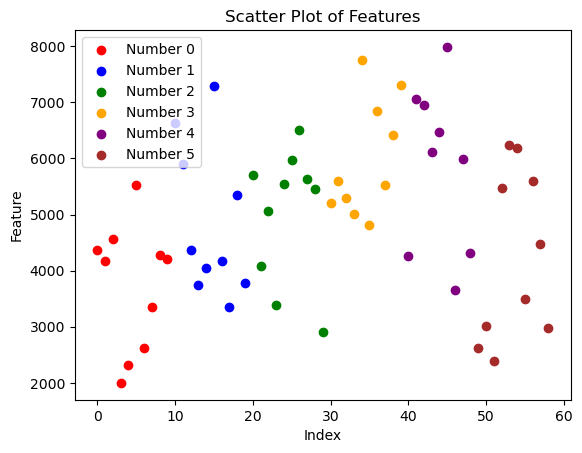

In [287]:
# Create an array of indices for each category
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices_2 = np.where(y_train == 2)[0]
indices_3 = np.where(y_train == 3)[0]
indices_4 = np.where(y_train == 4)[0]
indices_5 = np.where(y_train == 5)[0]

# Plot features with different colors for each category
plt.scatter(indices_0, training_features[indices_0], color='red', label='Number 0')
plt.scatter(indices_1, training_features[indices_1], color='blue', label='Number 1')
plt.scatter(indices_2, training_features[indices_2], color='green', label='Number 2')
plt.scatter(indices_3, training_features[indices_3], color='orange', label='Number 3')
plt.scatter(indices_4, training_features[indices_4], color='purple', label='Number 4')
plt.scatter(indices_5, training_features[indices_5], color='brown', label='Number 5')

plt.legend()  # Show legend
plt.xlabel('Index')
plt.ylabel('Feature')
plt.title('Scatter Plot of Features')

plt.show()

In [318]:
x_fit, x_test, y_fit, y_test = train_test_split(training_features, y_train, test_size=0.4, shuffle=True, stratify=labels)

# print(x_fit)
# print(x_test)
# print(y_fit)
# print(y_test)

clf = svm.SVC()

clf.fit(x_fit,y_fit)
y_predict = clf.predict(x_test)

score = accuracy_score(y_predict, y_test)

print('Accuracy: {} % '. format(score * 100))



Accuracy: 16.666666666666664 % 
